In [1]:
!pip install split-folders

### **Importing of Necessary Libraries**

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
import wandb
from wandb.keras import WandbCallback
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb_api") 
wandb.login(key=wandb_api)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### **Dataset Loading and Splitting**
Split-folders library was used to split the dataset into three parts: Training set(60%), Validation set(20%), and Test set(20%).

In [4]:
base_ds = '/kaggle/input/rosenet/Original Dataset'
base_ds = pathlib.Path(base_ds)

In [5]:
splitfolders.ratio(base_ds, output='imgs', seed=123, ratio=(.6,.2,.2), group_prefix=None)

Copying files: 917 files [00:08, 105.44 files/s]


In [6]:
Blackspot= [fn for fn in os.listdir(f'{base_ds}/Black Spot') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
DownyMildew= [fn for fn in os.listdir(f'{base_ds}/Downy Mildew') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
FreshLeaf= [fn for fn in os.listdir(f'{base_ds}/Fresh Leaf') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
#Die_Back= [fn for fn in os.listdir(f'{base_ds}/Die Back') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
#Gall_Midge= [fn for fn in os.listdir(f'{base_ds}/Gall Midge') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
#Healthy= [fn for fn in os.listdir(f'{base_ds}/Healthy') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
#Powdery_Mildew= [fn for fn in os.listdir(f'{base_ds}/Powdery Mildew') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
#Sooty_Mould= [fn for fn in os.listdir(f'{base_ds}/Sooty Mould') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]


coffee= [Blackspot, DownyMildew, FreshLeaf]
coffee_classes = []
for i in os.listdir('imgs/train'):
    coffee_classes+=[i]
coffee_classes.sort()



### **Dataset Exploration**
It can be seen here the total number of images in the dataset, the number of classes, and how well the images from each variety is distributed

Total images: 917
Total number of classes: 3
Total Black Spot images: 313
Total Downy Mildew images: 200
Total Fresh Leaf images: 404


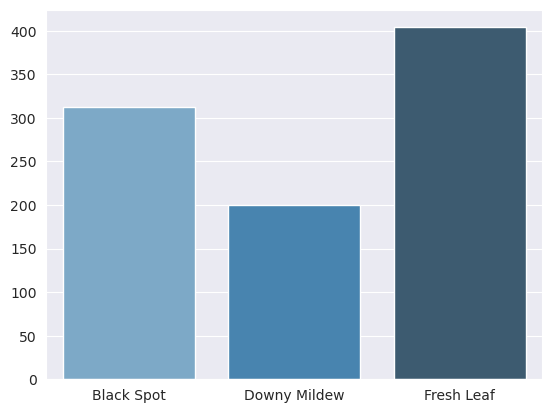

In [7]:
image_count1= len(list(base_ds.glob('*/*.jpg')))
image_count2 = len(list(base_ds.glob('*/*.jpeg')))
image_count=image_count1+image_count2
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(coffee_classes)}')
count = 0
coffee_count = []
for x in coffee_classes:
  print(f'Total {x} images: {len(coffee[count])}')
  coffee_count.append(len(coffee[count]))
  count+=1

sns.set_style('darkgrid')
sns.barplot(x=coffee_classes, y=coffee_count, palette="Blues_d")
plt.show()

### Sample Images
Each image from the dataset has a dimension of 250 by 250 and a color type of RGB

Image dimensions: (1396, 1109, 3)


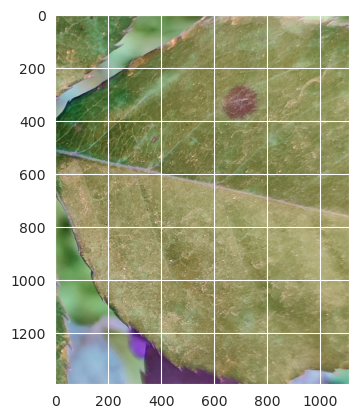

In [8]:
sample_img = cv2.imread('/kaggle/input/rosenet/Original Dataset/Black Spot/Black Spot (1).jpg')
plt.imshow(sample_img)
print(f'Image dimensions: {sample_img.shape}')

In [9]:
def load_random_img(dir, label):
  plt.figure(figsize=(10,10))
  i=0
  for label in coffee_classes:
    i+=1
    plt.subplot(1,8, i)
    file = random.choice(os.listdir(f'{dir}/{label}'))
    image_path = os.path.join(f'{dir}/{label}', file)
    img=cv2.imread(image_path)
    plt.title(label)
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')

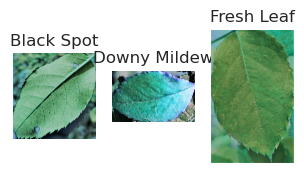

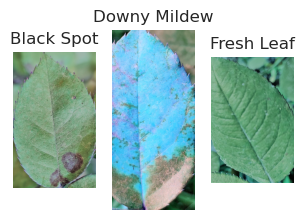

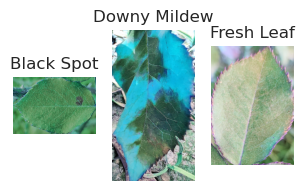

In [10]:
for i in range(3):
  load_random_img(base_ds,coffee_classes)

In [11]:
batch_size =16
img_height, img_width =128,128
input_shape = (img_height, img_width, 3)

CONFIG=dict(
            batch_size =16,
            img_height=128,
            img_width =128,
            )

### **Data Pre-processing**

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255,
                               rotation_range=30,
                               zoom_range=0.15,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.15,
                               horizontal_flip=True,
                               fill_mode="nearest")

test_datagen=ImageDataGenerator(rescale=1./255)

In [13]:
train_ds = train_datagen.flow_from_directory(
    'imgs/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    class_mode='categorical',
    shuffle=True
    )

val_ds = train_datagen.flow_from_directory(
    'imgs/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

test_ds = test_datagen.flow_from_directory(
    'imgs/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Found 549 images belonging to 3 classes.
Found 182 images belonging to 3 classes.
Found 186 images belonging to 3 classes.


In [14]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

CONFIG['model_name'] = 'ResNet50V2'
print('Training configuration: ', CONFIG)

# Initialize W&B run
run = wandb.init(settings=wandb.Settings(start_method="fork"),
                 reinit=True,
                 project='Rose',
                 entity="sanjeevsharma22",
                 config=CONFIG,
                 group='ResNet50V2', 
                 job_type='train')

wandb.config.type = 'baseline'

In [15]:
CONFIG['model_name'] = 'ResNet50V2'
print('Training configuration: ', CONFIG)

# Initialize W&B run
run = wandb.init(settings=wandb.Settings(start_method="fork"),
                 reinit=True,
                 project='Rose',
                 entity="sanjeevsharma22",
                 config=CONFIG,
                 group='ResNet50V2', 
                 job_type='train')

wandb.config.type = 'baseline'

wandb: Currently logged in as: sanjeevsharma22. Use `wandb login --relogin` to force relogin


Training configuration:  {'batch_size': 16, 'img_height': 128, 'img_width': 128, 'model_name': 'ResNet50V2'}


wandb: Tracking run with wandb version 0.15.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20230606_064003-u2n6ko7e
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run swift-spaceship-22
wandb: ⭐️ View project at https://wandb.ai/sanjeevsharma22/Rose
wandb: 🚀 View run at https://wandb.ai/sanjeevsharma22/Rose/runs/u2n6ko7e


## **Transfer Learning**

In [16]:
model=tf.keras.applications.ResNet50V2(weights="imagenet", include_top=False, input_shape=input_shape)
model.trainable = True
inputs = tf.keras.Input(input_shape)
x = model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)
model= tf.keras.Model(inputs, x)

94668760/94668760 [==============================] - 12s 0us/step


In [17]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 25,666,051
Trainable params: 25,620,611
Non-trainable params: 45,440
____________________________________________

## **Fine Tuning**

In [18]:
history3 =model.fit(train_ds, epochs =30, validation_data = val_ds,callbacks=[WandbCallback()])
run.finish()

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/30
35/35 [==============================] - ETA: 0s - loss: 0.9510 - accuracy: 0.5337

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_064003-u2n6ko7e/files/model-best)... Done. 1.3s


35/35 [==============================] - 88s 1s/step - loss: 0.9510 - accuracy: 0.5337 - val_loss: 0.7718 - val_accuracy: 0.6044
Epoch 2/30
35/35 [==============================] - ETA: 0s - loss: 0.5555 - accuracy: 0.7468

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_064003-u2n6ko7e/files/model-best)... Done. 1.7s


35/35 [==============================] - 48s 1s/step - loss: 0.5555 - accuracy: 0.7468 - val_loss: 0.4446 - val_accuracy: 0.8242
Epoch 3/30
35/35 [==============================] - ETA: 0s - loss: 0.3297 - accuracy: 0.8652

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_064003-u2n6ko7e/files/model-best)... Done. 1.3s


35/35 [==============================] - 46s 1s/step - loss: 0.3297 - accuracy: 0.8652 - val_loss: 0.3525 - val_accuracy: 0.8571
Epoch 4/30
35/35 [==============================] - ETA: 0s - loss: 0.2659 - accuracy: 0.9016

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_064003-u2n6ko7e/files/model-best)... Done. 1.3s


35/35 [==============================] - 48s 1s/step - loss: 0.2659 - accuracy: 0.9016 - val_loss: 0.2754 - val_accuracy: 0.8956
Epoch 5/30
35/35 [==============================] - ETA: 0s - loss: 0.2085 - accuracy: 0.9253

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_064003-u2n6ko7e/files/model-best)... Done. 1.3s


35/35 [==============================] - 45s 1s/step - loss: 0.2085 - accuracy: 0.9253 - val_loss: 0.1993 - val_accuracy: 0.9231
Epoch 6/30
35/35 [==============================] - ETA: 0s - loss: 0.1707 - accuracy: 0.9290

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_064003-u2n6ko7e/files/model-best)... Done. 1.2s


35/35 [==============================] - 45s 1s/step - loss: 0.1707 - accuracy: 0.9290 - val_loss: 0.1707 - val_accuracy: 0.9286
Epoch 7/30
35/35 [==============================] - ETA: 0s - loss: 0.1538 - accuracy: 0.9454

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_064003-u2n6ko7e/files/model-best)... Done. 1.2s


35/35 [==============================] - 46s 1s/step - loss: 0.1538 - accuracy: 0.9454 - val_loss: 0.1345 - val_accuracy: 0.9341
Epoch 8/30
35/35 [==============================] - 13s 373ms/step - loss: 0.1424 - accuracy: 0.9472 - val_loss: 0.1848 - val_accuracy: 0.9286
Epoch 9/30
35/35 [==============================] - ETA: 0s - loss: 0.1134 - accuracy: 0.9581

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_064003-u2n6ko7e/files/model-best)... Done. 1.2s


35/35 [==============================] - 45s 1s/step - loss: 0.1134 - accuracy: 0.9581 - val_loss: 0.1199 - val_accuracy: 0.9341
Epoch 10/30
35/35 [==============================] - 14s 411ms/step - loss: 0.1120 - accuracy: 0.9581 - val_loss: 0.1627 - val_accuracy: 0.9451
Epoch 11/30
35/35 [==============================] - ETA: 0s - loss: 0.0856 - accuracy: 0.9709

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_064003-u2n6ko7e/files/model-best)... Done. 1.3s


35/35 [==============================] - 45s 1s/step - loss: 0.0856 - accuracy: 0.9709 - val_loss: 0.0987 - val_accuracy: 0.9505
Epoch 12/30
35/35 [==============================] - 15s 427ms/step - loss: 0.0730 - accuracy: 0.9836 - val_loss: 0.1901 - val_accuracy: 0.9286
Epoch 13/30
35/35 [==============================] - 13s 387ms/step - loss: 0.1206 - accuracy: 0.9581 - val_loss: 0.1653 - val_accuracy: 0.9341
Epoch 14/30
35/35 [==============================] - ETA: 0s - loss: 0.0928 - accuracy: 0.9654

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_064003-u2n6ko7e/files/model-best)... Done. 1.2s


35/35 [==============================] - 44s 1s/step - loss: 0.0928 - accuracy: 0.9654 - val_loss: 0.0953 - val_accuracy: 0.9725
Epoch 15/30
35/35 [==============================] - 14s 402ms/step - loss: 0.1113 - accuracy: 0.9672 - val_loss: 0.1488 - val_accuracy: 0.9396
Epoch 16/30
35/35 [==============================] - 13s 381ms/step - loss: 0.0919 - accuracy: 0.9709 - val_loss: 0.1143 - val_accuracy: 0.9725
Epoch 17/30
35/35 [==============================] - 13s 370ms/step - loss: 0.0775 - accuracy: 0.9763 - val_loss: 0.1353 - val_accuracy: 0.9451
Epoch 18/30
35/35 [==============================] - 13s 386ms/step - loss: 0.0734 - accuracy: 0.9745 - val_loss: 0.1663 - val_accuracy: 0.9505
Epoch 19/30
35/35 [==============================] - 13s 377ms/step - loss: 0.0508 - accuracy: 0.9872 - val_loss: 0.1077 - val_accuracy: 0.9670
Epoch 20/30
35/35 [==============================] - 14s 388ms/step - loss: 0.0513 - accuracy: 0.9836 - val_loss: 0.1447 - val_accuracy: 0.9505
Epoch 2

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_064003-u2n6ko7e/files/model-best)... Done. 1.3s


35/35 [==============================] - 45s 1s/step - loss: 0.0569 - accuracy: 0.9818 - val_loss: 0.0901 - val_accuracy: 0.9725
Epoch 25/30
35/35 [==============================] - 14s 412ms/step - loss: 0.0376 - accuracy: 0.9854 - val_loss: 0.1231 - val_accuracy: 0.9451
Epoch 26/30
35/35 [==============================] - 13s 368ms/step - loss: 0.0358 - accuracy: 0.9854 - val_loss: 0.1422 - val_accuracy: 0.9396
Epoch 27/30
35/35 [==============================] - ETA: 0s - loss: 0.0297 - accuracy: 0.9891

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_064003-u2n6ko7e/files/model-best)... Done. 1.3s


35/35 [==============================] - 45s 1s/step - loss: 0.0297 - accuracy: 0.9891 - val_loss: 0.0589 - val_accuracy: 0.9835
Epoch 28/30
35/35 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 0.9964

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_064003-u2n6ko7e/files/model-best)... Done. 1.2s


35/35 [==============================] - 46s 1s/step - loss: 0.0183 - accuracy: 0.9964 - val_loss: 0.0505 - val_accuracy: 0.9780
Epoch 29/30
35/35 [==============================] - 15s 430ms/step - loss: 0.0508 - accuracy: 0.9836 - val_loss: 0.1127 - val_accuracy: 0.9725
Epoch 30/30
35/35 [==============================] - 13s 370ms/step - loss: 0.0442 - accuracy: 0.9836 - val_loss: 0.0940 - val_accuracy: 0.9615


wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb:     accuracy ▁▄▆▇▇▇▇▇▇▇██▇█████████████████
wandb:        epoch ▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
wandb:         loss █▅▃▃▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: val_accuracy ▁▅▆▆▇▇▇▇▇▇▇▇▇█▇█▇▇█▇█▇▇█▇▇████
wandb:     val_loss █▅▄▃▂▂▂▂▂▂▁▂▂▁▂▂▂▂▂▂▂▁▁▁▂▂▁▁▂▁
wandb: 
wandb: Run summary:
wandb:      accuracy 0.98361
wandb:    best_epoch 27
wandb: best_val_loss 0.05053
wandb:         epoch 29
wandb:          loss 0.04423
wandb:  val_accuracy 0.96154
wandb:      val_loss 0.09401
wandb: 
wandb: 🚀 View run swift-spaceship-22 at: https://wandb.ai/sanjeevsharma22/Rose/runs/u2n6ko7e
wandb: Synced 6 W&B file(s), 1 media file(s), 65 artifact file(s) and 1 other file(s)
wandb: Find logs at: ./wandb/run-20230606_064003-u2n6ko7e/logs


## **Final Evaluation**

In [19]:
run = wandb.init(settings=wandb.Settings(start_method="fork"),
                 reinit=True,
                 project='Rose', 
                 config=CONFIG,
                 group='ResNet50V2', 
                 job_type='evaluate') # Note the job_type

# Update `wandb.config`
wandb.config.type = 'baseline'

# Evaluate model
score3 =model.evaluate(test_ds, verbose=1)

# Finish the run
run.finish()

wandb: Tracking run with wandb version 0.15.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20230606_065700-tt0j1dw1
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run revived-forest-24
wandb: ⭐️ View project at https://wandb.ai/sanjeevsharma22/Rose
wandb: 🚀 View run at https://wandb.ai/sanjeevsharma22/Rose/runs/tt0j1dw1


12/12 [==============================] - 5s 412ms/step - loss: 0.0219 - accuracy: 0.9839


wandb: Waiting for W&B process to finish... (success).
wandb: 🚀 View run revived-forest-24 at: https://wandb.ai/sanjeevsharma22/Rose/runs/tt0j1dw1
wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20230606_065700-tt0j1dw1/logs


In [20]:
print(f'Pretrained Network Fine-tuned "\n"Loss: {score3[0]},"\n" Accuracy: {score3[1]*100}')

Pretrained Network Fine-tuned "
"Loss: 0.021867651492357254,"
" Accuracy: 98.38709831237793


In [21]:
Y_pred =model.predict(test_ds)

12/12 [==============================] - 4s 255ms/step


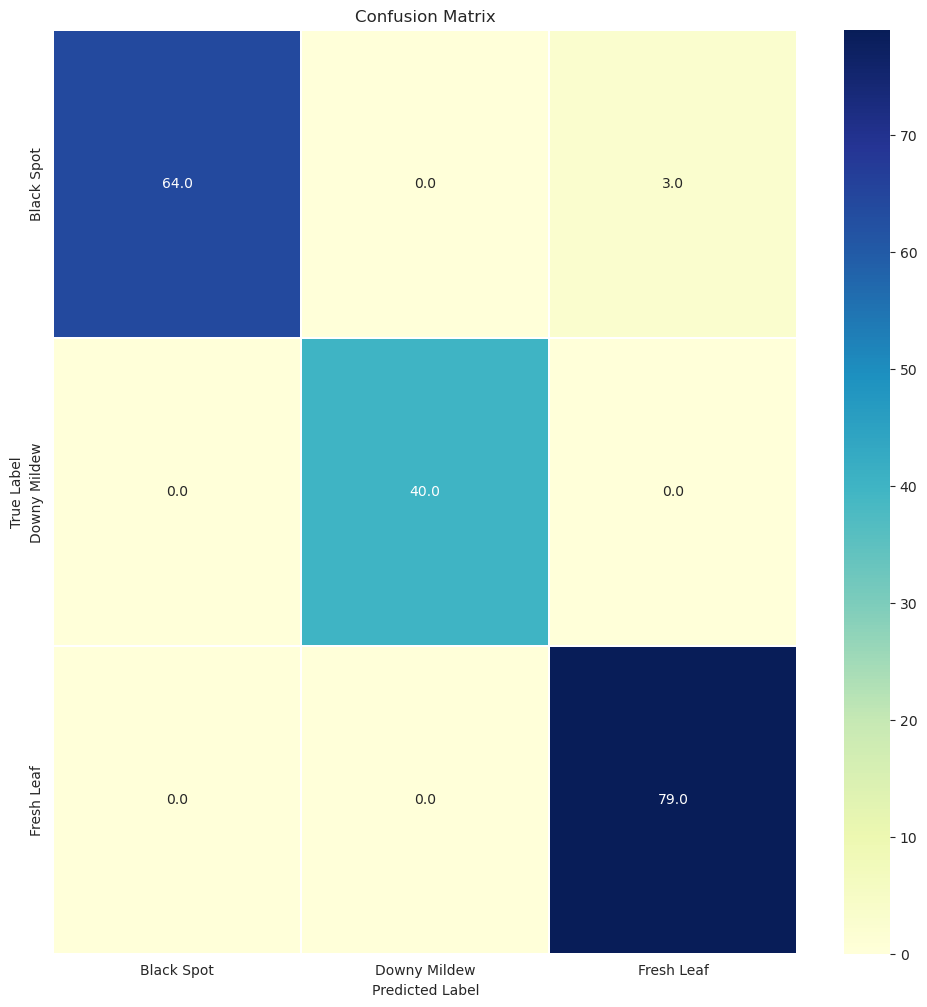

In [22]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,
           cmap="YlGnBu",)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(coffee_classes)
plt.title("Confusion Matrix")
plt.show()

In [23]:
report2 = classification_report(test_ds.classes, y_pred, target_names=coffee_classes, output_dict=True)
df2 = pd.DataFrame(report2).transpose()
df2

,precision,recall,f1-score,support
Black Spot,0.955224,1.000000,0.977099,64.000000
Downy Mildew,1.000000,1.000000,1.000000,40.000000
Fresh Leaf,1.000000,0.963415,0.981366,82.000000
accuracy,0.983871,0.983871,0.983871,0.983871
macro avg,0.985075,0.987805,0.986155,186.000000
weighted avg,0.984593,0.983871,0.983905,186.000000


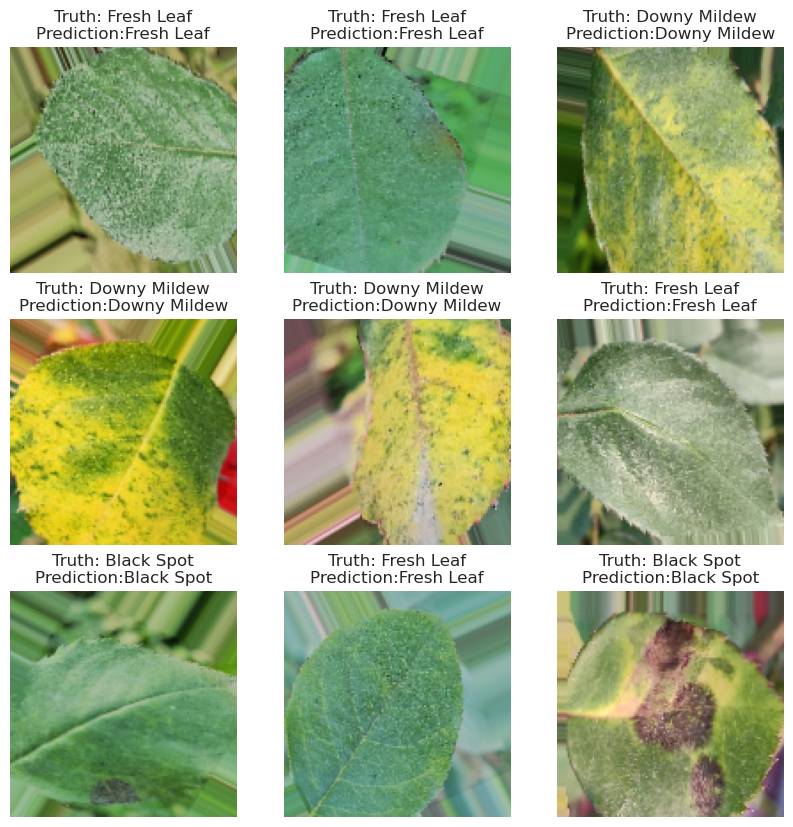

In [24]:
plt.figure(figsize=(10, 10))
x, label= train_ds.next()
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict =model(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label =coffee_classes[np.argmax(score)]
    plt.title(f'Truth: {coffee_classes[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)

In [25]:
model.save('ResNet50V2-baseline.h5')

# Initialize a new W&B run
run = wandb.init(settings=wandb.Settings(start_method="fork"),
                 reinit=True,
                 project='Rose', 
                 config=CONFIG,
                 group='ResNet50V2', 
                 job_type='save') # Note the job_type

# Update `wandb.config`
wandb.config.type = 'baseline'

# Save model as Model Artifact
artifact = wandb.Artifact(name='ResNet50V2', type='model')
artifact.add_file('ResNet50V2-baseline.h5')
run.log_artifact(artifact)

# Finish W&B run
run.finish()

wandb: Tracking run with wandb version 0.15.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20230606_065808-rn4s6fry
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run breezy-galaxy-25
wandb: ⭐️ View project at https://wandb.ai/sanjeevsharma22/Rose
wandb: 🚀 View run at https://wandb.ai/sanjeevsharma22/Rose/runs/rn4s6fry
wandb: Waiting for W&B process to finish... (success).
wandb: 🚀 View run breezy-galaxy-25 at: https://wandb.ai/sanjeevsharma22/Rose/runs/rn4s6fry
wandb: Synced 5 W&B file(s), 0 media file(s), 1 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20230606_065808-rn4s6fry/logs


<h2>Support by giving an upvote!!</h2>